#### Imports

In [206]:
# Import sklearn/tensorflow modules.
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, f1_score

# Import other modules.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import os
from time import sleep
from sportsipy.mlb.teams import Teams
from plyer import notification
from IPython.display import clear_output
%matplotlib inline

dataset = pd.read_csv('data.csv')
display(dataset)


,Team,League,Year,RS,RA,W,OBP,SLG,BA,Playoffs,RankSeason,RankPlayoffs,G,OOBP,OSLG
0,ARI,NL,2012,734,688,81,0.328,0.418,0.259,0,NaN,NaN,162,0.317,0.415
1,ATL,NL,2012,700,600,94,0.320,0.389,0.247,1,4.0,5.0,162,0.306,0.378
2,BAL,AL,2012,712,705,93,0.311,0.417,0.247,1,5.0,4.0,162,0.315,0.403
3,BOS,AL,2012,734,806,69,0.315,0.415,0.260,0,NaN,NaN,162,0.331,0.428
4,CHC,NL,2012,613,759,61,0.302,0.378,0.240,0,NaN,NaN,162,0.335,0.424
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1227,PHI,NL,1962,705,759,81,0.330,0.390,0.260,0,NaN,NaN,161,NaN,NaN
1228,PIT,NL,1962,706,626,93,0.321,0.394,0.268,0,NaN,NaN,161,NaN,NaN
1229,SFG,NL,1962,878,690,103,0.341,0.441,0.278,1,1.0,2.0,165,NaN,NaN
1230,STL,NL,1962,774,664,84,0.335,0.394,0.271,0,NaN,NaN,163,NaN,NaN


#### Remove unecessary columns

In [207]:
print(dataset.columns)
print(np.unique(dataset['Year']))    # spans from 1962 - 2012

sleep(7)
clear_output()

print(dataset.isnull().sum())
dataset.drop(columns=['RankSeason', 'RankPlayoffs', 'OOBP', 'OSLG', 'RS', 'RA', 'W', 'G'], inplace=True)

# NOTE: We drop columns like OOBP because of null values.
#       We drop columns like W, RS, and RA because that would give away target.

Team              0
League            0
Year              0
RS                0
RA                0
W                 0
OBP               0
SLG               0
BA                0
Playoffs          0
RankSeason      988
RankPlayoffs    988
G                 0
OOBP            812
OSLG            812
dtype: int64


In [204]:
dataset = dataset.iloc[::-1]    # Reversing dataset... so year increases w/index number

display(dataset)

,Team,League,Year,OBP,SLG,BA,Playoffs
1231,WSA,AL,1962,0.308,0.373,0.250,0
1230,STL,NL,1962,0.335,0.394,0.271,0
1229,SFG,NL,1962,0.341,0.441,0.278,1
1228,PIT,NL,1962,0.321,0.394,0.268,0
1227,PHI,NL,1962,0.330,0.390,0.260,0
...,...,...,...,...,...,...,...
4,CHC,NL,2012,0.302,0.378,0.240,0
3,BOS,AL,2012,0.315,0.415,0.260,0
2,BAL,AL,2012,0.311,0.417,0.247,1
1,ATL,NL,2012,0.320,0.389,0.247,1


#### Add more data from `sportsipy` module

In [208]:
ERA = []
ERA_PLUS = []
FIP = []
HR = []
RBIs = []
Ks = []

notification.notify(
    title='Data preparation loading...',
    message=f'Estimated time until data is loaded: 27 min.',
    app_icon='jupyter_icon.ico'
)

for row in dataset.index:
    team = dataset.loc[row]['Team']
    year = dataset.loc[row]['Year']

    team_object = Teams(year)[team]
    
    ERA.append(team_object.earned_runs_against)
    ERA_PLUS.append(team_object.earned_runs_against_plus)
    FIP.append(team_object.fielding_independent_pitching)
    HR.append(team_object.home_runs)
    RBIs.append(team_object.runs_batted_in)
    Ks.append(team_object.strikeouts)


dataset['ERA'] = ERA
dataset['ERA+'] = ERA_PLUS
dataset['FIP'] = FIP
dataset['HR'] = HR
dataset['RBIs'] = RBIs
dataset['Ks'] = Ks

# Add samples from 2013-2021.
for year in range(2013, 2022):
    if year != 2020:
        for team in Teams(year)._teams:
            team_ = Teams(year)[team.abbreviation]    # This is the team object.
            
            if team_.rank >= 10:    # 10 teams make the playoffs every year (starting in 2022 it's 15 teams)
                playoff_label = 1
            else:
                playoff_label = 0

            sample = [
                team_.abbreviation, 
                'N/A', year, 
                team_.on_base_percentage, 
                team_.slugging_percentage, 
                team_.batting_average, 
                playoff_label, 
                team_.earned_runs_against, 
                team_.earned_runs_against_plus, 
                team_.fielding_independent_pitching, 
                team_.home_runs, 
                team_.runs_batted_in, 
                team_.strikeouts
            ]
    
            dataset.loc[len(dataset.index)] = sample

# NOTE: We can put N/A for league because it won't be used for the model.

notification.notify(
    title='All data loaded',
    message=f'View can view the data in your code editor.',
    app_icon='jupyter_icon.ico'
)

display(dataset)


,Team,League,Year,OBP,SLG,BA,Playoffs,ERA,ERA+,FIP,HR,RBIs,Ks
0,ARI,NL,2012,0.328,0.418,0.259,0,3.93,104,3.80,165,710,1200
1,ATL,NL,2012,0.320,0.389,0.247,1,3.42,117,3.74,149,660,1232
2,BAL,AL,2012,0.311,0.417,0.247,1,3.90,109,4.20,214,677,1177
3,BOS,AL,2012,0.315,0.415,0.260,0,4.70,90,4.41,165,695,1176
4,CHC,NL,2012,0.302,0.378,0.240,0,4.51,91,4.46,137,570,1128
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1467,WSN,N/A,2021,0.337,0.417,0.258,1,4.80,84,4.87,182,686,1346
1468,PIT,N/A,2021,0.309,0.364,0.236,1,5.08,84,4.74,124,570,1312
1469,TEX,N/A,2021,0.294,0.375,0.232,1,4.79,92,4.76,167,598,1239
1470,BAL,N/A,2021,0.304,0.402,0.239,1,5.84,77,5.15,195,632,1234


#### More data preparation

In [209]:
target = (dataset['Playoffs'])
data_moneyball = (dataset[['OBP', 'SLG', 'FIP']])    # chosing these stats because these are valued most.
data_all = (dataset[['OBP', 'SLG', 'BA', 'ERA', 'ERA+', 'FIP', 'Ks', 'HR', 'RBIs']])

display(target)
display(data_moneyball)
display(data_all)

# ---- VARIABLE DESCRIPTIONS ----
# OBP:          on-base percentage
# SLG:          slugging percentage
# BA:           batting average
# Playoffs:     binary (if team made playoffs or not)
# ERA:          earned run average
# ERA+:         earned run average +
# FIP:          fielding independent pitching
# HR:           home runs
# RBIs:         runs batted in
# Ks:           strikeouts

target = target.to_numpy()
data_moneyball = data_moneyball.to_numpy()
data_all = data_all.to_numpy()


0       0
1       1
2       1
3       0
4       0
       ..
1467    1
1468    1
1469    1
1470    1
1471    1
Name: Playoffs, Length: 1472, dtype: int64

,OBP,SLG,FIP
0,0.328,0.418,3.80
1,0.320,0.389,3.74
2,0.311,0.417,4.20
3,0.315,0.415,4.41
4,0.302,0.378,4.46
...,...,...,...
1467,0.337,0.417,4.87
1468,0.309,0.364,4.74
1469,0.294,0.375,4.76
1470,0.304,0.402,5.15


,OBP,SLG,BA,ERA,ERA+,FIP,Ks,HR,RBIs
0,0.328,0.418,0.259,3.93,104,3.80,1200,165,710
1,0.320,0.389,0.247,3.42,117,3.74,1232,149,660
2,0.311,0.417,0.247,3.90,109,4.20,1177,214,677
3,0.315,0.415,0.260,4.70,90,4.41,1176,165,695
4,0.302,0.378,0.240,4.51,91,4.46,1128,137,570
...,...,...,...,...,...,...,...,...,...
1467,0.337,0.417,0.258,4.80,84,4.87,1346,182,686
1468,0.309,0.364,0.236,5.08,84,4.74,1312,124,570
1469,0.294,0.375,0.232,4.79,92,4.76,1239,167,598
1470,0.304,0.402,0.239,5.84,77,5.15,1234,195,632


#### Split up data

X_train.shape: (1104, 3); y_train.shape: (1104,)
X_test.shape: (368, 3); y_test.shape: (368,)


Text(0.5, 0, 'FIP')

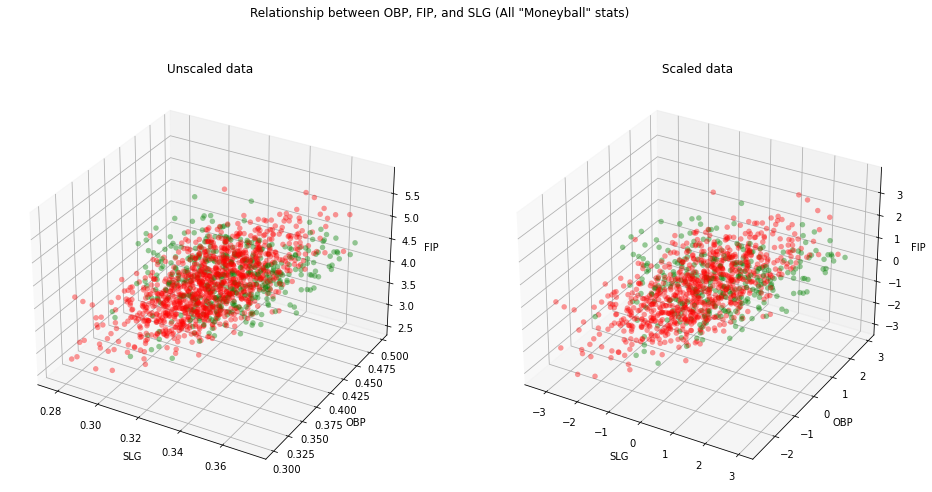

In [210]:
X_train, X_test, y_train, y_test = train_test_split(data_moneyball, target, stratify=target)

def scale_data(train, test=''):
    scaler = StandardScaler()

    train_data = scaler.fit_transform(train)
    
    if type(test) != str:
        test_data = scaler.transform(test)
        return train_data, test_data
    else:
        return train_data

X_train, X_test = scale_data(X_train, X_test)
        

print(f'X_train.shape: {X_train.shape}; y_train.shape: {y_train.shape}')
print(f'X_test.shape: {X_test.shape}; y_test.shape: {y_test.shape}')

# Plot the data
fig = plt.figure(figsize=(16, 8))
    
title = fig.suptitle(f'Relationship between OBP, FIP, and SLG (All "Moneyball" stats)')
axs_1 = fig.add_subplot(1, 2, 1, projection='3d')
axs_1.title.set_text('Unscaled data')

xs = data_moneyball[:, 0]    # SLG
ys = data_moneyball[:, 1]    # OBP
zs = data_moneyball[:, 2]    # FIP
data_points = [(x, y, z) for x, y, z in zip(xs, ys, zs)]
colors = ['green' if tar == 1 else 'red' for tar in target]

for data, color in zip(data_points, colors):
    x, y, z = data
    axs_1.scatter(x, y, z, alpha=0.4, c=color, edgecolors='none', s=30)

axs_1.set_xlabel('SLG')
axs_1.set_ylabel('OBP')
axs_1.set_zlabel('FIP')

# Plot the scaled data.
axs_2 = fig.add_subplot(1, 2, 2, projection='3d')
axs_2.title.set_text('Scaled data')

xs = X_train[:, 0]    # SLG
ys = X_train[:, 1]    # OBP
zs = X_train[:, 2]    # FIP
data_points = [(x, y, z) for x, y, z in zip(xs, ys, zs)]
colors = ['green' if tar == 1 else 'red' for tar in y_train]

for data, color in zip(data_points, colors):
    x, y, z = data
    axs_2.scatter(x, y, z, alpha=0.4, c=color, edgecolors='none', s=30)

axs_2.set_xlabel('SLG')
axs_2.set_ylabel('OBP')
axs_2.set_zlabel('FIP')


#### Create model to simulate moneyball theory

In [211]:
moneyball_model = LogisticRegression()
moneyball_model.fit(X_train, y_train)

print(f'Training Accuracy: {moneyball_model.score(X_train, y_train)*100:.2f}%')
print(f'Testing Accuracy: {moneyball_model.score(X_test, y_test)*100:.2f}%')

# NOTE: 3-5% increase in accuracy after scaler.


Training Accuracy: 70.47%
Testing Accuracy: 70.11%


#### Test model between two different time periods (1962 - 1993 & 1994 - 2012)

In [212]:
def time_period_test(year, symbol):
    if symbol == '<':
        dataset_time_period = dataset.loc[dataset['Year'] < year]
    elif symbol == '>':
        dataset_time_period = dataset.loc[dataset['Year'] > year]
    else:
        print(f"Invalid symbol '{symbol}'")

    data_time_period = (dataset_time_period[['SLG', 'OBP', 'FIP']]).to_numpy()
    target_time_period = (dataset_time_period['Playoffs']).to_numpy()

    data_time_period = scale_data(data_time_period)
    
    model = LogisticRegression()
    model.fit(data_time_period, target_time_period)
    accuracy = model.score(data_time_period, target_time_period)

    fig = plt.figure(figsize=(10, 8))
    
    title = fig.suptitle(f'Statistics from {symbol} {year}\n Model accuracy: {model.score(data_time_period, target_time_period)*100:.1f}%')
    ax = fig.add_subplot(111, projection='3d')

    xs = data_time_period[:, 0]    # SLG
    ys = data_time_period[:, 1]    # OBP
    zs = data_time_period[:, 2]    # FIP
    data_points = [(x, y, z) for x, y, z in zip(xs, ys, zs)]
    colors = ['green' if tar == 1 else 'red' for tar in target_time_period]

    for data, color in zip(data_points, colors):
        x, y, z = data
        ax.scatter(x, y, z, alpha=0.4, c=color, edgecolors='none', s=30)
    
    ax.set_xlabel('SLG')
    ax.set_ylabel('OBP')
    ax.set_zlabel('FIP')


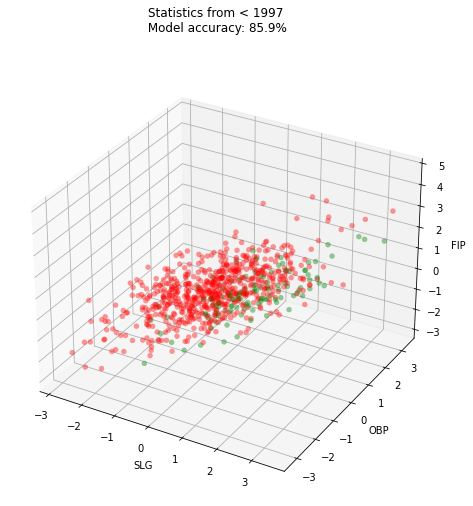

In [213]:
time_period_test(1997, '<')

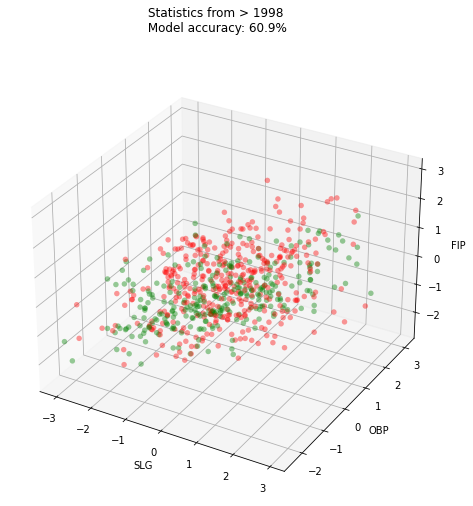

In [214]:
time_period_test(1998, '>')    # large decrease after steroids era... coincindence?

#### Create model that uses `data_all`

In [215]:
X_train, X_test, y_train, y_test = train_test_split(data_all, target, stratify=target)

X_train, X_test = scale_data(X_train, X_test)

model = LogisticRegression(max_iter=99999999)

model.fit(X_train, y_train)

print(f'Training Accuracy: {model.score(X_train, y_train)*100:.2f}%')
print(f'Testing Accuracy: {model.score(X_test, y_test)*100:.2f}%')

weights = model.coef_[0]
features = ['OBP', 'SLG', 'BA', 'ERA', 'ERA+', 'FIP', 'Ks', 'HR', 'RBIs']

features_plus_weights = [(feature, abs(round(weight, 3))) for feature, weight in zip(features, weights)]
features_plus_weights = sorted(features_plus_weights, key=lambda i: i[1])

print('\nWeight importance (sorted least to greatest):')
print(features_plus_weights)


Training Accuracy: 74.37%
Testing Accuracy: 73.64%

Weight importance (sorted least to greatest):
[('BA', 0.173), ('ERA+', 0.229), ('OBP', 0.269), ('HR', 0.303), ('FIP', 0.481), ('SLG', 0.549), ('Ks', 0.696), ('RBIs', 0.807), ('ERA', 1.125)]


Make manual test to see if a team would make the playoffs

In [216]:
def manual_test(team, year):
    team_object = Teams(year)[team]

    team_OBP = team_object.on_base_percentage
    team_SLG = team_object.slugging_percentage
    team_BA = team_object.batting_average
    team_ERA = team_object.earned_runs_against
    team_ERA_plus = team_object.earned_runs_against_plus
    team_FIP = team_object.fielding_independent_pitching
    team_Ks = team_object.strikeouts
    team_HR = team_object.home_runs
    team_RBIs = team_object.runs_batted_in

    sample = [team_OBP, team_SLG, team_BA, team_ERA, team_ERA_plus, team_FIP, team_Ks, team_HR, team_RBIs]
    sample = np.array(sample).reshape(1, -1)
    _, sample = scale_data(data_all, sample)    # Reinitializing scaler to scale sample.

    return f'Model prediction for {year} {team_object.abbreviation}: {model.predict(sample)[0]}'

for year in [2013, 2014, 2015, 2016, 2017, 2018, 2019, 2021]:    # Skip 2020 (COVID year with 60 games)
    print(manual_test('CHC', year))

# NOTE: all are right aside from 2019, but Cubs won 84 games and based on run differential, they were expected to win 90 games that season.


Model prediction for 2013 CHC: 0
Model prediction for 2014 CHC: 0
Model prediction for 2015 CHC: 1
Model prediction for 2016 CHC: 1
Model prediction for 2017 CHC: 1
Model prediction for 2018 CHC: 1
Model prediction for 2019 CHC: 1
Model prediction for 2021 CHC: 0


#### Conclusion
* Moneyball theory is still effective in predicting a ticket to the playoffs.
* We find that RBIs and ERA are more effective than OBP and SLG at predicting if a team will make the playoffs.

In [217]:
from sklearn.feature_selection import RFE

model_test = LogisticRegression(max_iter=99999999)

rfe = RFE(estimator=model_test)
rfe.fit(X_train, y_train)

rankings = rfe.ranking_
column_names = ['OBP', 'SLG', 'BA', 'ERA', 'ERA+', 'FIP', 'Ks', 'HR', 'RBIs']

combined = zip(column_names, rankings)

print(sorted(combined, key=lambda stat: stat[1]))


[('ERA', 1), ('FIP', 1), ('Ks', 1), ('RBIs', 1), ('OBP', 2), ('ERA+', 3), ('SLG', 4), ('HR', 5), ('BA', 6)]
